# Convolutional Neural Network (CNN) for Plant Disease Classification

This notebook trains (or loads) a CNN model to classify plant leaf images into disease categories using the **PlantVillage** dataset.

**Workflow**
1. Import libraries and set hyperparameters  
2. Load and explore the dataset  
3. Split into train/validation/test  
4. Build, compile, and train the CNN (or reload a saved model)  
5. Evaluate on the test set (accuracy, classification report, confusion matrix)  
6. Do basic error analysis


## 1. Imports
We import the main libraries used in this notebook: TensorFlow/Keras for the CNN, NumPy for arrays, and Matplotlib for plots.


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt

## 2. Basic configuration
Set the key hyperparameters: image size, batch size, number of channels (RGB), and training epochs.


In [2]:
image_size = (256) # 256x256 pixels
batch_size = 16 # images per batch
channels = 3 # RGB
epochs = 40 # number of training epochs


## 3. Load the dataset and exploratory data analysis 
Loads images from your `PlantVillage` directory. Each subfolder name becomes a class label automatically.


In [3]:
# Load images from a folder structure into a tf.data.Dataset.
# Expected folder layout:
#   ../data/raw/PlantVillage/
#       class_1/  (images...)
#       class_2/  (images...)
#       ...
# Each subfolder name becomes the class label automatically.
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "../data/raw/PlantVillage",     # root folder containing one subfolder per class
    image_size = (image_size, image_size),      # resize every image to this fixed size (H, W)
    batch_size = batch_size                     # how many images per batch returned by the dataset
)

# Result:
# - dataset yields batches of (images, labels)
# - images shape: (batch_size, image_size, image_size, 3)
# - labels are integer class IDs (e.g., 0..num_classes-1)


Found 46955 files belonging to 10 classes.


### Class names
Keras assigns an integer label to each class based on folder order. `class_names` stores the mapping.


In [4]:
# Get the list of class (label) names inferred from the subfolder names
# inside the PlantVillage directory.
# Example: ["Apple___Black_rot", "Apple___healthy", ...]
class_names = dataset.class_names

# Display / print the class names (in notebooks, the last line shows the value)
class_names



['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Mosaic_virus',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'Target_Spot',
 'YellowLeaf__Curl_Virus']

### Inspect one batch
Checks the tensor shapes coming from the dataset and prints the label ids in that batch.


In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)   # image batch shape
    print(label_batch.numpy()) # labels as numpy


(16, 256, 256, 3)
[7 8 5 5 1 9 1 2 4 9 2 4 8 4 2 6]


### Inspect one image shape
Shows the shape of a single image tensor (height, width, channels).


In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(256, 256, 3)


### Inspect raw pixel values
Prints raw pixel values for one image (before rescaling).


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())  # pixel values (array) of the first image in the batch



[[[148. 138. 136.]
  [137. 127. 125.]
  [190. 180. 178.]
  ...
  [133. 119. 116.]
  [118. 104. 101.]
  [117. 103. 100.]]

 [[141. 131. 129.]
  [120. 110. 108.]
  [146. 136. 134.]
  ...
  [136. 122. 119.]
  [136. 122. 119.]
  [131. 117. 114.]]

 [[129. 119. 117.]
  [147. 137. 135.]
  [144. 134. 132.]
  ...
  [131. 117. 114.]
  [140. 126. 123.]
  [146. 132. 129.]]

 ...

 [[186. 178. 175.]
  [183. 175. 172.]
  [179. 171. 168.]
  ...
  [130. 119. 117.]
  [137. 126. 124.]
  [141. 130. 128.]]

 [[183. 175. 172.]
  [179. 171. 168.]
  [177. 169. 166.]
  ...
  [145. 134. 132.]
  [157. 146. 144.]
  [142. 131. 129.]]

 [[187. 179. 176.]
  [186. 178. 175.]
  [191. 183. 180.]
  ...
  [126. 115. 113.]
  [140. 129. 127.]
  [141. 130. 128.]]]


### Visualize a sample image
Displays one example image from the dataset.


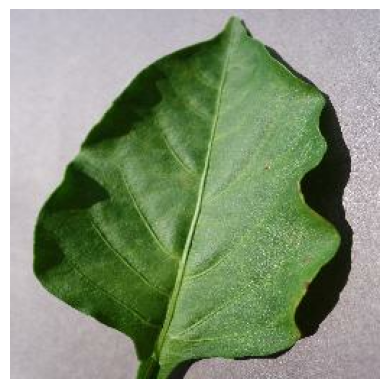

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # show first image (convert to uint8 for display)
    plt.axis("off")                                      # hide axes


### Label id → class name mapping
Prints the numeric label id for each class. **Note:** this cell previously contained extra code; it has been cleaned to only show the mapping.


In [9]:
for label_id, class_name in enumerate(dataset.class_names):
    print(f"{label_id} : {class_name}")  # print: class_index : class_name



0 : Bacterial_spot
1 : Early_blight
2 : Healthy
3 : Late_blight
4 : Leaf_Mold
5 : Mosaic_virus
6 : Septoria_leaf_spot
7 : Spider_mites_Two_spotted_spider_mite
8 : Target_Spot
9 : YellowLeaf__Curl_Virus


### Collect one sample per class
Unbatches the dataset and stores the first image seen for each class. This is useful for later visualization.


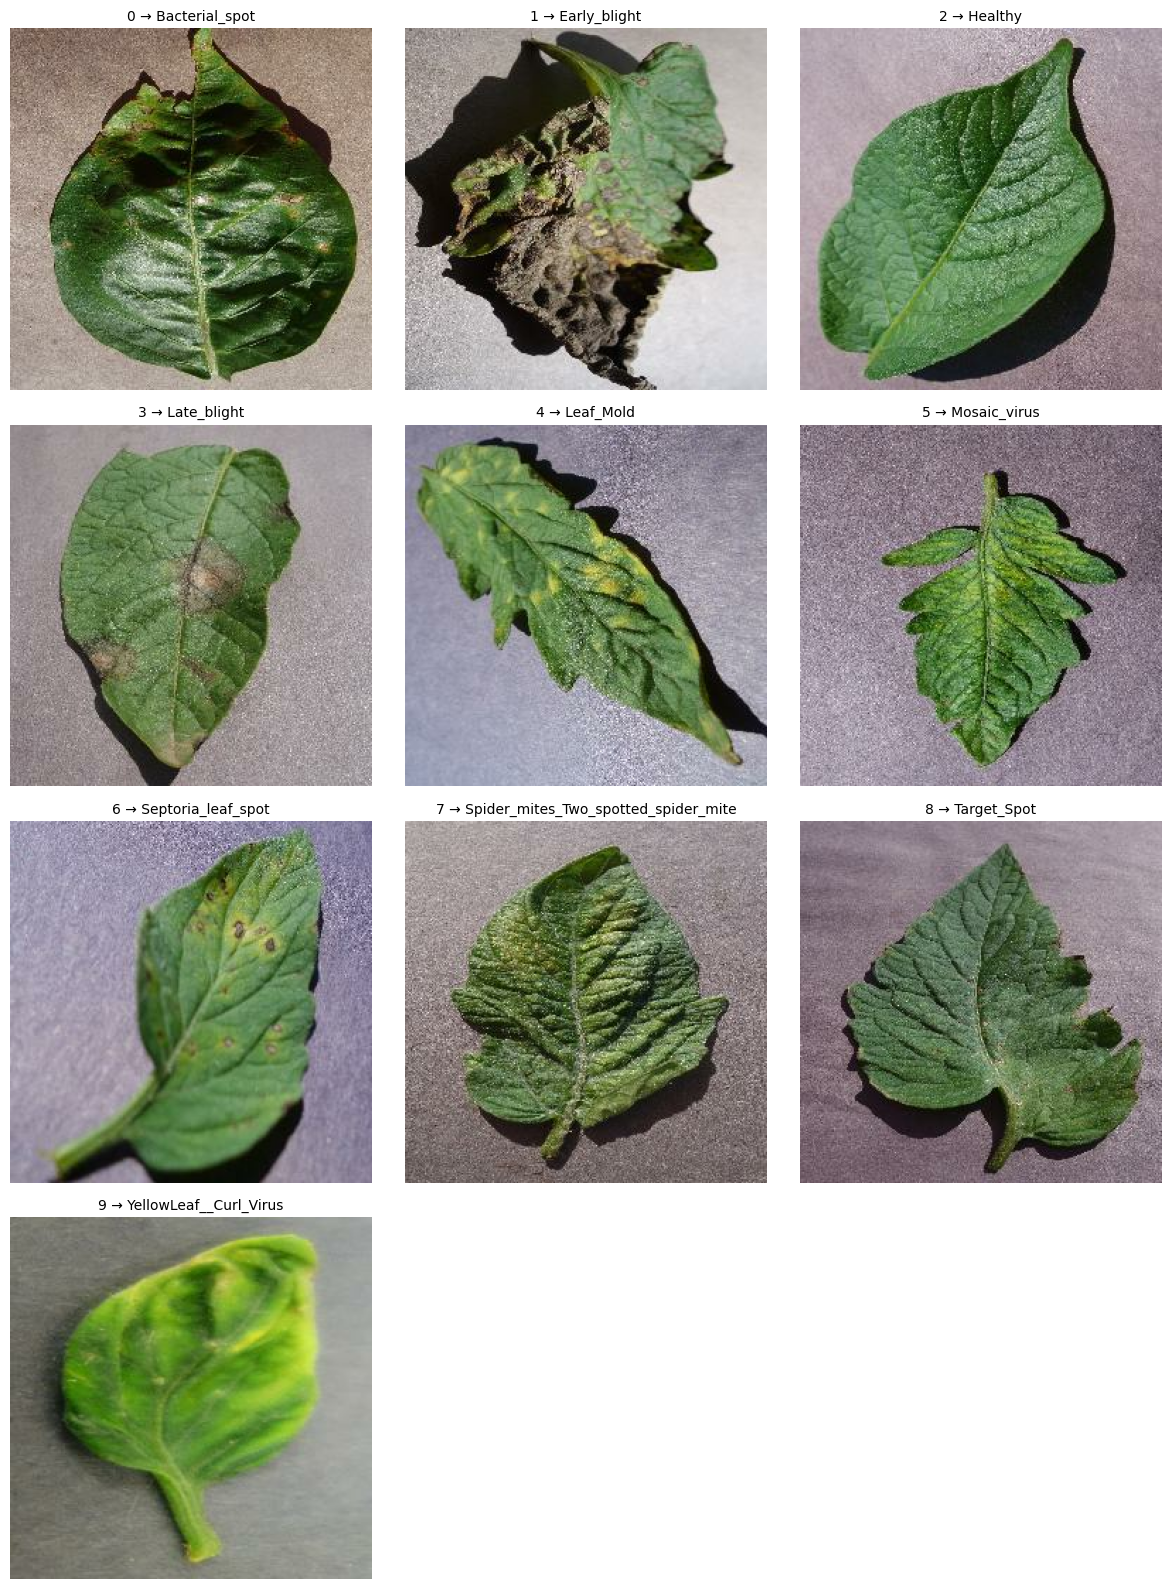

In [10]:
import math

class_names = dataset.class_names                 # class names (from folder names)
num_classes = len(class_names)                    # number of classes

samples = {}                                      # store 1 sample image per class

for img, label in dataset.unbatch():              # iterate image-by-image (not in batches)
    label_id = int(label.numpy())                 # tensor -> int
    if label_id not in samples:
        samples[label_id] = img                   # keep the first image for this class
    if len(samples) == num_classes:
        break                                     # stop after collecting all classes

cols = 3
rows = math.ceil(num_classes / cols)              # rows needed for the grid

plt.figure(figsize=(4*cols, 4*rows))
for i, label_id in enumerate(sorted(samples.keys())):
    ax = plt.subplot(rows, cols, i + 1)           # position in the grid

    img = samples[label_id].numpy().astype("uint8")  # convert to display format
    plt.imshow(img)                               # show image
    plt.title(f"{label_id} → {class_names[label_id]}", fontsize=10)  # label + name
    plt.axis("off")                               # hide axes

plt.tight_layout()                                # nicer spacing
plt.show()                                        # render the figure


## 4. Train/validation/test split
Splits a `tf.data.Dataset` into train/val/test using `take()` and `skip()`. This assumes the dataset has a known length.


In [11]:
import math

def spliting_the_data(ds, train_split=0.80, val_split=0.10, test_split=0.10,
                     shuffle=True, shuffle_size=1000, seed=12):
    """Split a *batched* tf.data.Dataset into train/val/test.

    Notes
    - This splits by **batches**, not by individual images.
    - Works well with `tf.keras.preprocessing.image_dataset_from_directory`.
    """
    # Get number of batches safely (avoid `len(ds)` which can be unknown).
    if hasattr(ds, "file_paths"):
        ds_size = int(math.ceil(len(ds.file_paths) / batch_size))
    else:
        card = tf.data.experimental.cardinality(ds).numpy()
        if card == tf.data.experimental.UNKNOWN_CARDINALITY:
            raise TypeError(
                "Dataset cardinality is unknown. Use a file_paths-based split."
            )
        ds_size = int(card)

    if shuffle:
        buffer = min(shuffle_size, ds_size)
        ds = ds.shuffle(buffer, seed=seed, reshuffle_each_iteration=False)

    train_size = int(train_split * ds_size)
    val_size   = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


### Create the splits
Runs the split function and produces `train_ds`, `val_ds`, and `test_ds`.


In [12]:
train_ds, val_ds, test_ds = spliting_the_data(dataset)  # split dataset into train/val/test



### Check split sizes
Shows the number of batches in each split (may be `unknown` in some pipelines).


In [13]:
def _cardinality(ds):
    c = tf.data.experimental.cardinality(ds).numpy()
    return int(c) if c >= 0 else c  # -2 means UNKNOWN_CARDINALITY

print("Train batches:", _cardinality(train_ds))
print("Val batches:  ", _cardinality(val_ds))
print("Test batches: ", _cardinality(test_ds))


Train batches: 2348
Val batches:   293
Test batches:  294


## 5. Preprocessing and data augmentation
- **Resizing** ensures all images have the same shape.
- **Rescaling** normalizes pixels to `[0, 1]`.
- **Augmentation** creates random flips/rotations to improve generalization.


In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),   # resize to fixed size
    layers.Rescaling(1.0/255)                  # normalize pixels to [0, 1]
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(height_factor=(-0.25, 0.10), width_factor=(-0.25, 0.10)),
    layers.RandomTranslation(height_factor=0.12, width_factor=0.12),
    layers.RandomContrast(0.25),
    layers.GaussianNoise(0.03),
], name="data_augmentation")


## 6. Build the CNN model


### Embed Class Names Inside the Saved Model 

This code creates a tiny custom Keras layer that does nothing to the data, but it stores the class labels (folder names) inside the model file when it is saved.
That way, when the model is loaded (e.g., in Streamlit), the class names could be directly read from the model, and they will automatically update whenever the model is retrain withed with new/changed classes.

In [15]:
@tf.keras.utils.register_keras_serializable(package="meta")
class ClassNamesLayer(tf.keras.layers.Layer):
    """Metadata-only layer that stores `class_names` inside the saved model.

    - Identity forward pass (does not change tensors).
    - Robust to Keras deserialization (avoids 'trainable passed twice' errors).
    """
    def __init__(self, class_names=None, **kwargs):
        kwargs.pop("trainable", None)   # avoid duplicates during load
        super().__init__(**kwargs)
        self.class_names = list(class_names) if class_names is not None else []
        self.trainable = False

    def call(self, inputs):
        return inputs

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"class_names": self.class_names})
        return cfg

    @classmethod
    def from_config(cls, config):
        return cls(**config)


### Model architecture
Defines a Sequential CNN: preprocessing → conv/pool blocks → flatten → dense → softmax. If you want a deeper network, add more conv/pool blocks.


In [29]:
input_shape = (image_size, image_size, channels)

class_names = list(dataset.class_names)
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=input_shape),

    # store class names inside the model file (no separate json needed)
    ClassNamesLayer(class_names=class_names, name="class_names"),

    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.30),
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 class_names (ClassNamesLay  (None, 256, 256, 3)       0         
 er)                                                             
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                      

### Compile the model
Sets the optimizer, loss function, and metrics. `SparseCategoricalCrossentropy` is correct when labels are integer-encoded.


In [56]:
model.compile(
    optimizer='adam',   # training algorithm (Adam optimizer)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # loss for integer labels + softmax output
    metrics=['accuracy']  # track accuracy during training/eval
)

model.summary()  # show model architecture + parameters


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 class_names (ClassNamesLay  (None, 256, 256, 3)       0         
 er)                                                             
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 data_augmentation (Sequent  (None, 256, 256, 3)       0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                      

### Early stopping 

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=5,
        restore_best_weights=True,
    ),
    ModelCheckpoint(
        "../models/best_model.keras",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        mode="min",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
]


### GPU setup (optional)
Enables memory growth so TensorFlow doesn't reserve all GPU memory at once.


In [58]:
import tensorflow as tf  # TensorFlow library

gpus = tf.config.list_physical_devices('GPU')          # list available GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # use GPU memory as needed (avoid full pre-allocation)

print("GPUs:", gpus)                                   # show detected GPUs



GPUs: []


### Train or load a saved model
Use `TRAIN = True` to train and save, or `TRAIN = False` to load the saved model from disk. This cell also prints TensorFlow/Keras versions and some file info.


In [ ]:
import os
import tensorflow as tf

# Save/load the Streamlit-ready model (contains embedded class names)
MODEL_PATH = "../models/best_model.keras"
TRAIN = False  # set False only when you want to load an existing saved model

custom_objects = {"ClassNamesLayer": ClassNamesLayer}

if TRAIN:
    print("Training model...")
    model_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )
    model.save(MODEL_PATH)
    print("✅ Saved model to:", MODEL_PATH)

else:
    if os.path.exists(MODEL_PATH):
        print("Loading saved model...")
        try:
            model = tf.keras.models.load_model(
                MODEL_PATH,
                custom_objects=custom_objects,
                compile=True,
                safe_mode=True,
            )
        except TypeError:
            model = tf.keras.models.load_model(
                MODEL_PATH,
                custom_objects=custom_objects,
                compile=True,
            )
        print("✅ Loaded model from:", MODEL_PATH)
    else:
        raise FileNotFoundError(
            f"Model not found at: {MODEL_PATH}\n"
            "Either fix the path or set TRAIN=True to train and save the model."
        )


Loading saved model...
✅ Loaded model from: ../models/best_model.keras


In [74]:
print("optimizer:", getattr(model, "optimizer", None))
print("metrics_names:", getattr(model, "metrics_names", None))
print("compiled?", getattr(model, "optimizer", None) is not None)


optimizer: <keras.src.optimizers.adam.Adam object at 0x000001CB701EDD10>
metrics_names: []
compiled? True


### Testing and model evaluation
Returns test loss and test accuracy.


In [64]:
import tensorflow as tf

last = model.layers[-1]
act = getattr(last, "activation", None)
act_name = act.__name__ if act is not None else "None"

from_logits = (act is None) or (act_name == "linear")

print("Last layer:", last.__class__.__name__)
print("Last activation:", act_name)
print("Using from_logits =", from_logits)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=["accuracy"],
)


Last layer: Dense
Last activation: softmax
Using from_logits = False


In [61]:
if "scores" not in globals():
    scores = model.evaluate(test_ds, verbose=1)   # ✅ save it so it becomes "cached"
else:
    print("✅ Using cached scores (not re-evaluating).")

print("metrics:", model.metrics_names)
print("scores :", scores)
print("as dict:", dict(zip(model.metrics_names, scores)))




294/294 [==============================] - 261s 256ms/step - loss: 0.2305 - accuracy: 0.9301
metrics: ['loss', 'accuracy']
scores : [0.23052261769771576, 0.930059552192688]
as dict: {'loss': 0.23052261769771576, 'accuracy': 0.930059552192688}


### Predict labels on the test set
Collects true labels and predicted labels so we can build a classification report and confusion matrix.


In [62]:
y_true_list = []                      # store true labels from all batches
y_pred_list = []                      # store predicted labels from all batches

for x_batch, y_batch in test_ds:      # loop over test batches (images, labels)
    probs = model.predict(x_batch, verbose=0)   # predicted class probabilities
    y_pred_batch = np.argmax(probs, axis=1)     # pick class with highest probability

    y_true_batch = y_batch.numpy()    # true labels as numpy

    y_true_list.append(y_true_batch)  # collect true labels
    y_pred_list.append(y_pred_batch)  # collect predicted labels

y_true = np.concatenate(y_true_list)  # merge all true labels into one array
y_pred = np.concatenate(y_pred_list)  # merge all predictions into one array

print("Manual test accuracy:", (y_true == y_pred).mean())  # compare with model.evaluate accuracy


Manual test accuracy: 0.9302721088435374


### Confusion matrix plot
Shows where the model confuses one class for another.


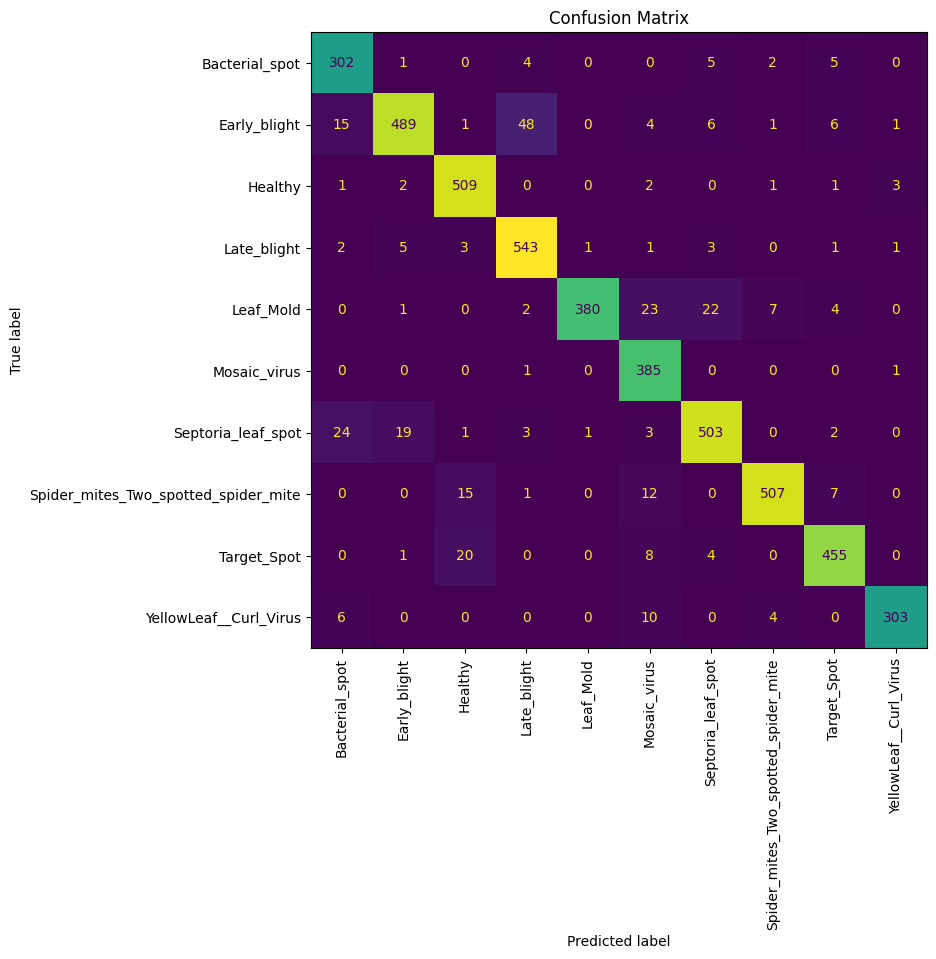

In [63]:
import matplotlib.pyplot as plt
import numpy as np

try:
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, xticks_rotation=90, colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

except ModuleNotFoundError:
    # No sklearn installed: use TensorFlow confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(class_names)).numpy()
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)
    plt.colorbar(im, ax=ax)
    plt.show()


### Classification report
Precision/recall/F1-score per class, plus macro and weighted averages.


In [65]:
try:
    from sklearn.metrics import classification_report

    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4,
    ))

except ModuleNotFoundError:
    # Simple per-class metrics without sklearn
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(class_names)).numpy()

    tp = np.diag(cm).astype(float)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp

    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) != 0)
    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) != 0)
    f1        = np.divide(2 * precision * recall, precision + recall,
                          out=np.zeros_like(tp), where=(precision + recall) != 0)

    print("Per-class metrics (no sklearn):")
    for name, p, r, f in zip(class_names, precision, recall, f1):
        print(f"{name:30s}  precision={p:.3f}  recall={r:.3f}  f1={f:.3f}")


                                      precision    recall  f1-score   support

                      Bacterial_spot     0.8629    0.9467    0.9028       319
                        Early_blight     0.9440    0.8564    0.8981       571
                             Healthy     0.9271    0.9807    0.9532       519
                         Late_blight     0.9020    0.9696    0.9346       560
                           Leaf_Mold     0.9948    0.8656    0.9257       439
                        Mosaic_virus     0.8594    0.9948    0.9222       387
                  Septoria_leaf_spot     0.9263    0.9047    0.9154       556
Spider_mites_Two_spotted_spider_mite     0.9713    0.9354    0.9530       542
                         Target_Spot     0.9459    0.9324    0.9391       488
              YellowLeaf__Curl_Virus     0.9806    0.9381    0.9589       323

                            accuracy                         0.9303      4704
                           macro avg     0.9314    0.9324    0

### Inspect wrong predictions
Collects a few misclassified examples so you can visually check what went wrong.


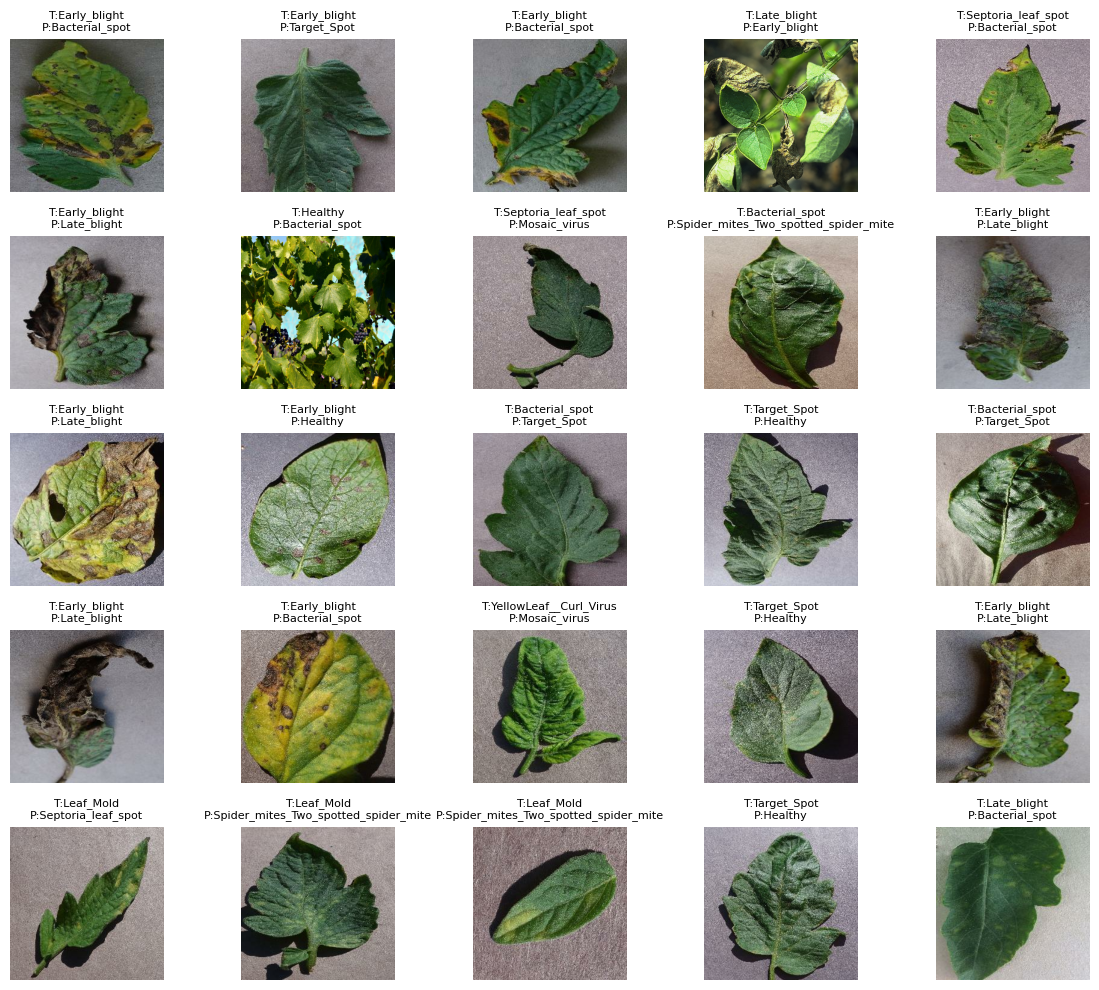

In [66]:
import matplotlib.pyplot as plt   # plotting
import numpy as np                # arrays

wrong = []  # store (image, true_label, pred_label) for mistakes

for x_batch, y_batch in test_ds:                      # loop over test batches
    probs = model.predict(x_batch, verbose=0)         # predict probabilities
    pred = np.argmax(probs, axis=1)                   # predicted class ids

    if len(y_batch.shape) > 1 and y_batch.shape[-1] > 1:  # if labels are one-hot
        true = np.argmax(y_batch.numpy(), axis=1)          # convert to class ids
    else:
        true = y_batch.numpy().astype(int)                 # sparse labels -> int

    for i in range(len(true)):                             # check each item in batch
        if true[i] != pred[i]:
            wrong.append((x_batch[i].numpy().astype("uint8"), true[i], pred[i]))  # save mistake
    if len(wrong) >= 25:
        break                                              # stop after collecting 25 mistakes

plt.figure(figsize=(12, 10))                               # create figure
for i, (img, t, p) in enumerate(wrong[:25]):               # plot up to 25 wrong images
    plt.subplot(5, 5, i+1)
    plt.imshow(img)                                       # show image
    t_name = class_names[t] if "class_names" in globals() else str(t)  # true name
    p_name = class_names[p] if "class_names" in globals() else str(p)  # pred name
    plt.title(f"T:{t_name}\nP:{p_name}", fontsize=8)       # title (T=true, P=pred)
    plt.axis("off")                                       # hide axes
plt.tight_layout()                                        # spacing
plt.show()                                                # display


### Error analysis 

In [67]:
import numpy as np  # arrays + numerical ops

pairs = []                          # store (count, true_class_name, predicted_class_name)
n = len(class_names)                # number of classes

for i in range(n):                  # loop over true class index
    for j in range(n):              # loop over predicted class index
        if i != j and cm[i, j] > 0: # keep only mistakes (off-diagonal) with count > 0
            pairs.append((cm[i, j], class_names[i], class_names[j]))  # save this confusion pair

for c, true_name, pred_name in sorted(pairs, reverse=True)[:15]:  # top 15 biggest confusions
    print(f"{c:>3}  True: {true_name:30s}  → Pred: {pred_name}")   # print nicely formatted


 48  True: Early_blight                    → Pred: Late_blight
 24  True: Septoria_leaf_spot              → Pred: Bacterial_spot
 23  True: Leaf_Mold                       → Pred: Mosaic_virus
 22  True: Leaf_Mold                       → Pred: Septoria_leaf_spot
 20  True: Target_Spot                     → Pred: Healthy
 19  True: Septoria_leaf_spot              → Pred: Early_blight
 15  True: Spider_mites_Two_spotted_spider_mite  → Pred: Healthy
 15  True: Early_blight                    → Pred: Bacterial_spot
 12  True: Spider_mites_Two_spotted_spider_mite  → Pred: Mosaic_virus
 10  True: YellowLeaf__Curl_Virus          → Pred: Mosaic_virus
  8  True: Target_Spot                     → Pred: Mosaic_virus
  7  True: Spider_mites_Two_spotted_spider_mite  → Pred: Target_Spot
  7  True: Leaf_Mold                       → Pred: Spider_mites_Two_spotted_spider_mite
  6  True: YellowLeaf__Curl_Virus          → Pred: Bacterial_spot
  6  True: Early_blight                    → Pred: Target_Spot

The main remaining errors are concentrated in a few visually similar categories—especially Spider_mites → Target_Spot (9) and Spider_mites → healthy (8), plus smaller mix-ups like Septoria_leaf_spot → Early_blight (5). This is reasonable because these classes can share similar “spotty” textures, and symptoms may be subtle or appear in early stages, making the visual cues harder even for humans.

## 12. Streamlit Cloud checklist
- Use **Python 3.11** (`runtime.txt`: `python-3.11.9` or similar)
- Use a **minimal** `requirements.txt` for deployment (do NOT include conda `environment.yml`)
- Avoid installing standalone `keras` separately (TensorFlow installs the compatible Keras)

**Minimal `requirements.txt`**
```txt
streamlit
tensorflow==2.15.0
numpy==1.26.4
pillow
```

**In Streamlit `app.py`** load with:
```python
model = tf.keras.models.load_model(
    "models/image_classification_model_with_names.keras",
    custom_objects={"ClassNamesLayer": ClassNamesLayer},
    compile=False
)
```

- Make sure your deployed model file is the one saved in section **Train or load a saved model** (`image_classification_model_with_names.keras`).

## 13. Environment setup (local training) + deployment requirements

### Recommended versions (avoid Streamlit Cloud install errors)
- **Python:** 3.11.x  
  (TensorFlow 2.15 does **not** have wheels for Python 3.12+ in many environments)
- **TensorFlow:** `2.15.0`
- **Keras:** use `tf.keras` (installed automatically with TensorFlow 2.15)

### Create a clean virtual environment (Windows / PowerShell)
```powershell
# inside your project folder
py -3.11 -m venv .venv
.\.venv\Scripts\Activate.ps1

python -m pip install --upgrade pip
```

### Install packages for training (Jupyter + plots)
```powershell
pip install tensorflow==2.15.0 numpy==1.26.4 matplotlib pillow
```

Optional (only if you want sklearn reports):
```powershell
pip install scikit-learn
```

### Install packages for Streamlit (deployment)
Create a `requirements.txt` in your repo root:
```txt
streamlit
tensorflow==2.15.0
numpy==1.26.4
pillow
```

Create a `runtime.txt` in your repo root:
```txt
python-3.11.9
```

### Important Streamlit notes
- Commit/push the **saved model** (`models/image_classification_model_with_names.keras`) to GitHub, or load it from another storage location.
- In `app.py`, load with:
```python
model = tf.keras.models.load_model(
    "models/image_classification_model_with_names.keras",
    custom_objects={"ClassNamesLayer": ClassNamesLayer},
    compile=False
)
```


### Optional fallback: export a SavedModel folder (if `.keras` fails on Streamlit Cloud)
Sometimes deployment environments can be picky about loading a single `.keras` file. If you hit loading errors, export a SavedModel folder after training:

```python
import shutil, os, numpy as np

SAVEDMODEL_DIR = "../models/savedmodel_with_names"

# build once (ensures model is built for export)
_ = model(np.zeros((1,) + tuple(dataset.element_spec[0].shape[1:]), dtype=np.float32), training=False)

if os.path.exists(SAVEDMODEL_DIR):
    shutil.rmtree(SAVEDMODEL_DIR)

model.export(SAVEDMODEL_DIR)
print("✅ Exported SavedModel to:", SAVEDMODEL_DIR)
```

Then deploy the folder and load it in Streamlit with:
```python
model = tf.keras.models.load_model("models/savedmodel_with_names", compile=False)
```
